# 8章 Attention

## 8.1 Attentionの仕組み

Attention mechanism(注意機構)

seq2seqを大きく改良する

### 8.1.1 seq2seqの問題点

Encoderの出力が「固定長のベクトル」であるところに問題がある

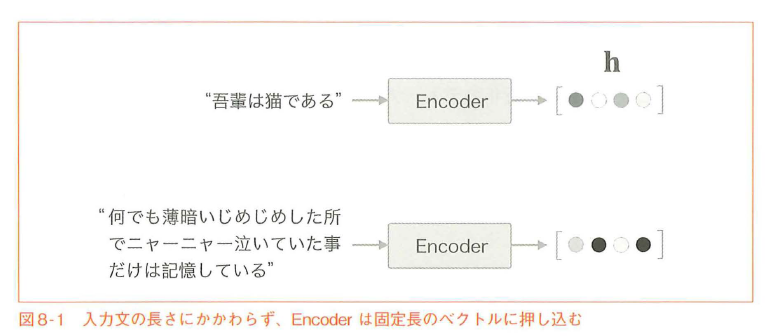

### 8.1.2 Encoderの改良

LSTMの最後の隠れ状態だけをDecoderに渡していたところを、入力の文章の長さに応じてEncoderの出力も変わるように、  
#### 各時刻のLSTMの隠れ状態ベクトルを全て利用する

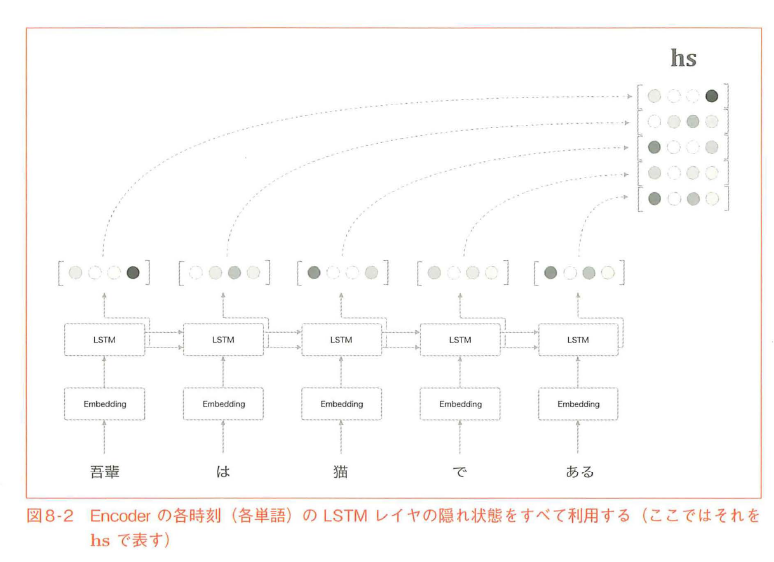

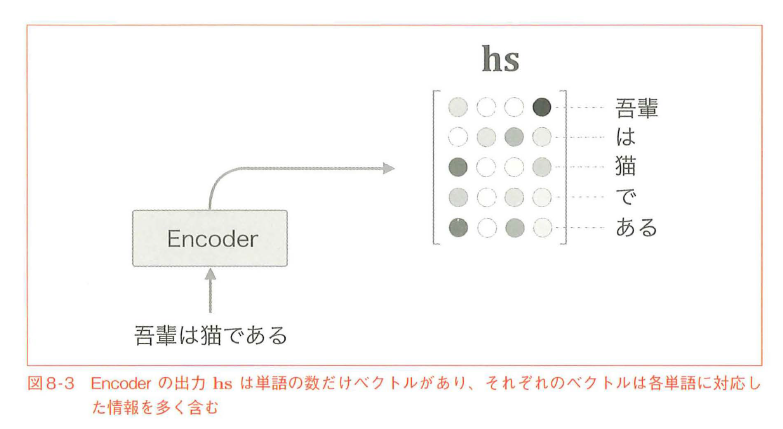

### 8.1.3 Decoderの改良①

Encoderが出力した各単語に対応するLSTMの隠れ状態ベクトルを「hs」として出力し、それをDecoderが受け取り時系列変換する

「入力と出力でどの単語が関連しているのか」という対応関係をseq2seqに学習させることはできないかを考える

「翻訳先の単語」と対応関係にある「翻訳元の単語」の情報を選び出すこと、必要な情報にだけに注意を向けさせること

→Attention

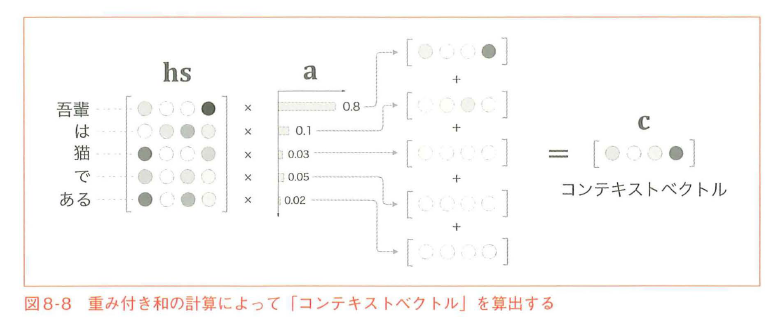

微分可能な演算を用いれば誤差逆伝播法を用いることができる

・「選ぶ」操作
「すべて選ぶ」ようにして「重み」を計算する

単語の重み付き和を計算

この結果を「コンテキストベクトル」と呼ぶ

In [5]:
import numpy as np

T, H = 5, 4 #時系列の長さＴ, 隠れ状態ベクトルの要素数Ｈ
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(5, 1).repeat(4, axis=1) # aをarに変換
# aの形状（5,）→（5, 1）
print(ar.shape)
# (5, 4)

t = hs * ar
print(t.shape)
# (5, 4)

c = np.sum(t, axis=0)
print(c.shape)
# (4,)

(5, 4)
(5, 4)
(4,)


In [6]:
# バッチ処理版の重み付き和の実装
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a= np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis=2)
# ar = a.reshape(N, T, 1) ＃ブロードキャストを使う場合

t = hs * ar
print(t.shape)
# (10, 5, 4)

c = np.sum(t, axis=1)
print(c.shape)
# (10, 4)

(10, 5, 4)
(10, 4)


計算グラフの逆伝播を考える  
「Repeatの逆伝播はSum」「Sumの逆伝播はRepeat」

In [7]:
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Softmax


class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1)#.repeat(T, axis=1)
        t = hs * ar
        c = np.sum(t, axis=1)

        self.cache = (hs, ar)
        return c

    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)

        return dhs, da

### 8.1.4 Decoderの改良②

aを求める

hがhsの各単語ベクトルとどれだけ似ているかを数値で表す  
→結果を「s」で表す。正規化には「softmax関数」を用いる

内積によって計算

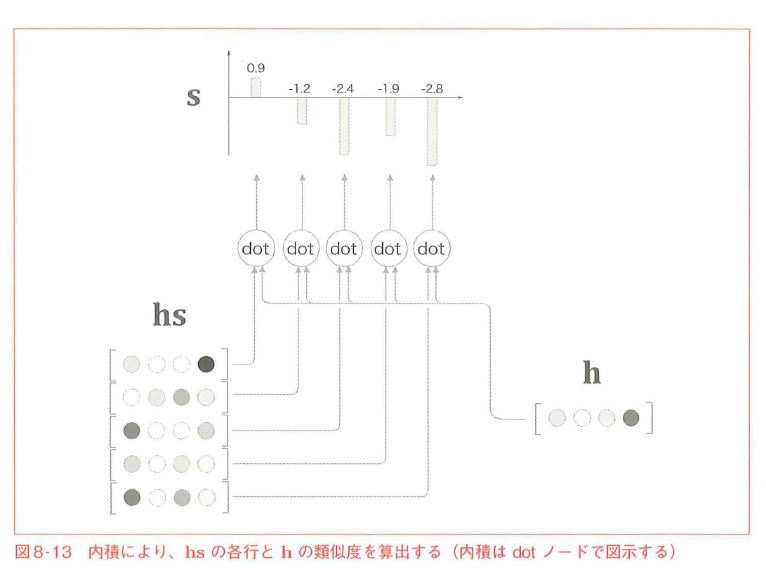

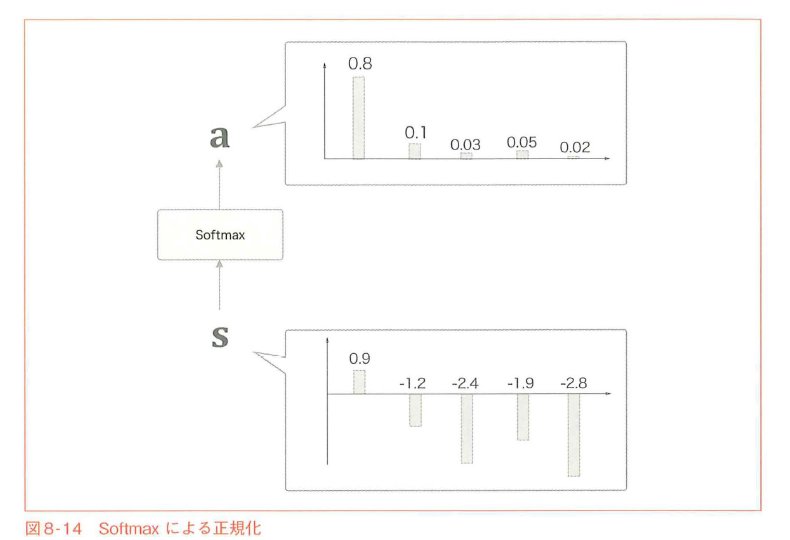

In [8]:
# aを求める
# ミニバッチ処理を行う
import sys
sys.path.append('..')
from common.layers import Softmax
import numpy as np

N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
h = np.random.randn(N, H)
hr = h.reshape(N, 1, H).repeat(T, axis=1)
#hr= h.reshape(N, 1, HJ ＃ブロードキャストの場合

t = hs * hr
print(t.shape)
# (10, 5, 4)

s = np.sum(t, axis=2)
print(s.shape)
# (10, 5)

softmax = Softmax()
a = softmax.forward(s)
print(a.shape)
# (10, 5)

(10, 5, 4)
(10, 5)
(10, 5)


Attentionweightクラスを実装

In [9]:
class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)#.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh

### 8.1.5 Decoderの改良③

Attention WeightレイヤとWeight Sumレイヤを組み合わせる

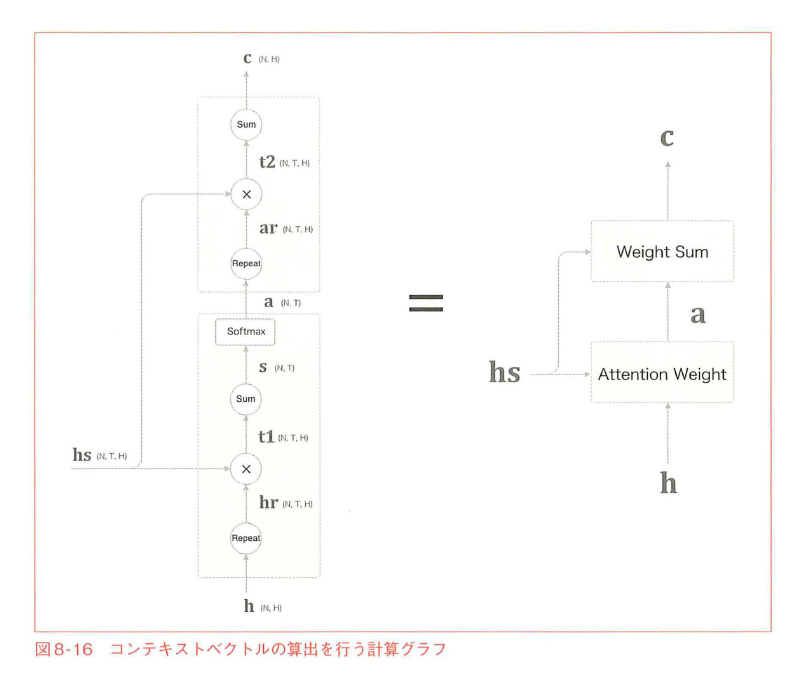

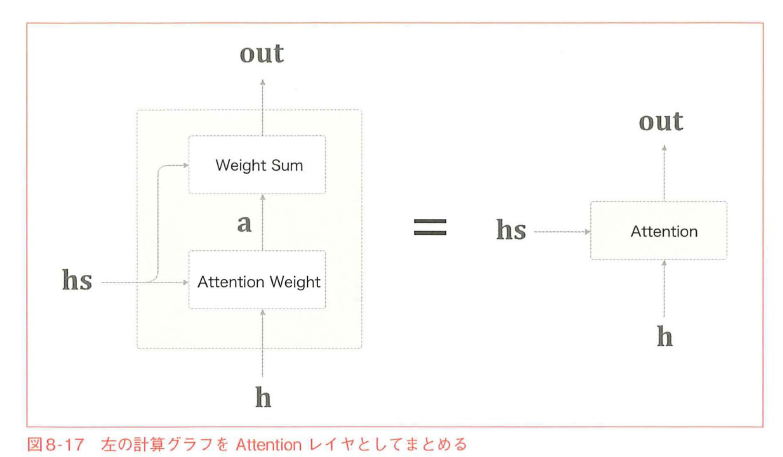

コンテキストベクトルcを算出し、上層(今回はAffine)へ伝播

In [10]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

複数のAttentionをまとめたTime Attentionレイヤを実装

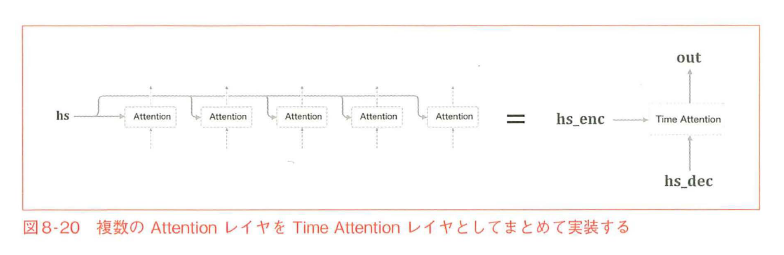

In [12]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = [] # 各単語の重みをリストとする

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec

## 8.2 Attention付きseq2seqの実装

### 8.2.1 Encoderの実装

LSTMの最後の隠れ状態ベクトルだけを返していたところ、全ての隠れ状態を返す

In [13]:
import sys
sys.path.append('..')
from common.time_layers import *
from ch07.seq2seq import Encoder, Seq2seq
from ch08.attention_layer import TimeAttention


class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### 8.2.2 Decoderの実装

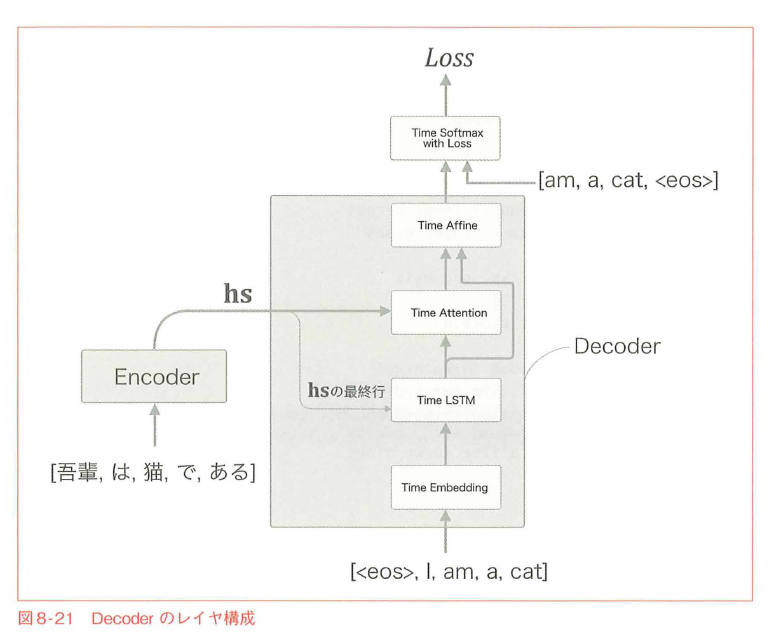

In [14]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2) 
        # TimeAttentionの出力とLSTMの出力を結合
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

### 8.2.3 seq2seqの実装

In [15]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

## 8.3 Attentionの評価

「日付フォーマット」を変更する問題に挑戦

### 8.3.1 日付フォーマットの変換問題

年、月、日の対応関係に注意を払えるか確認

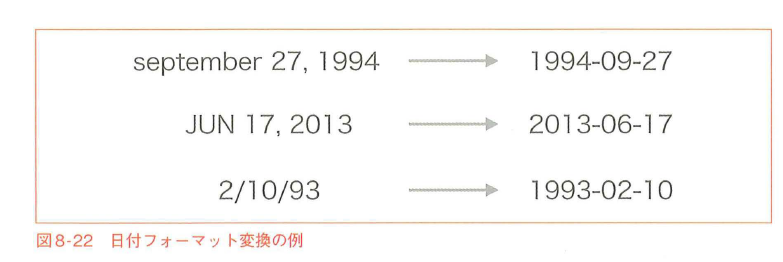

### 8.3.2 Attention付きseq2seqの学習

In [2]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq


# データの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 入力文を反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))


model.save_params()

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 5[s] | loss 3.09
| epoch 1 |  iter 41 / 351 | time 10[s] | loss 1.90
| epoch 1 |  iter 61 / 351 | time 15[s] | loss 1.72
| epoch 1 |  iter 81 / 351 | time 20[s] | loss 1.46
| epoch 1 |  iter 101 / 351 | time 25[s] | loss 1.19
| epoch 1 |  iter 121 / 351 | time 30[s] | loss 1.14
| epoch 1 |  iter 141 / 351 | time 35[s] | loss 1.09
| epoch 1 |  iter 161 / 351 | time 40[s] | loss 1.06
| epoch 1 |  iter 181 / 351 | time 45[s] | loss 1.04
| epoch 1 |  iter 201 / 351 | time 50[s] | loss 1.03
| epoch 1 |  iter 221 / 351 | time 55[s] | loss 1.02
| epoch 1 |  iter 241 / 351 | time 60[s] | loss 1.02
| epoch 1 |  iter 261 / 351 | time 65[s] | loss 1.01
| epoch 1 |  iter 281 / 351 | time 70[s] | loss 1.00
| epoch 1 |  iter 301 / 351 | time 75[s] | loss 1.00
| epoch 1 |  iter 321 / 351 | time 80[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 86[s] | loss 1.00
Q 10/15/94                     
T 1994-10-15
☒ 1978-08

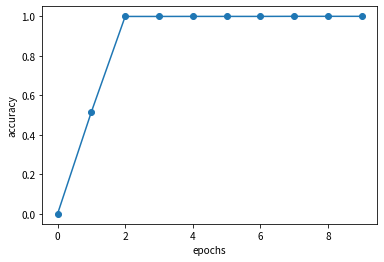

In [3]:
# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.show()

単純なseq2seqは使い物にならないが、AttentionやPeekyは同程度の結果になった

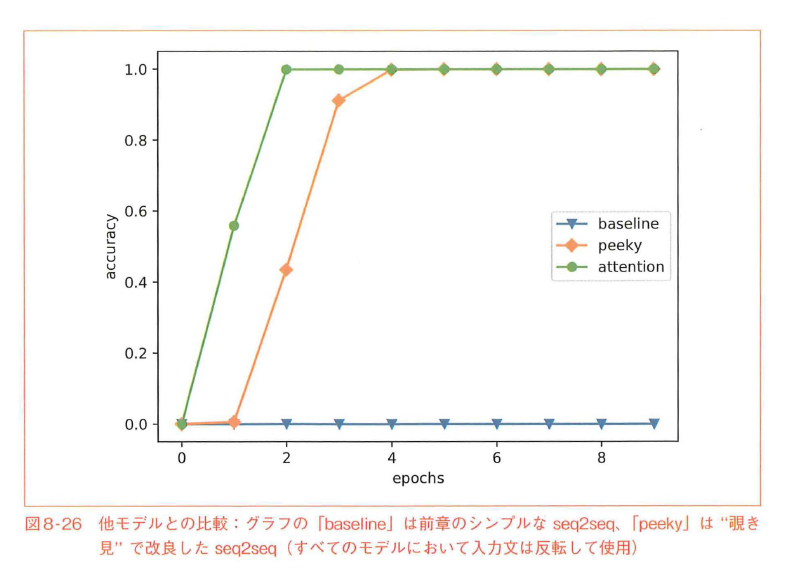

### 8.3.3 Attentionの可視化

どこに注意を払っているのかを重みとメンバ変数から可視化

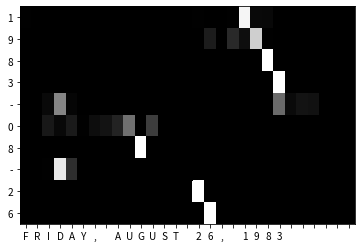

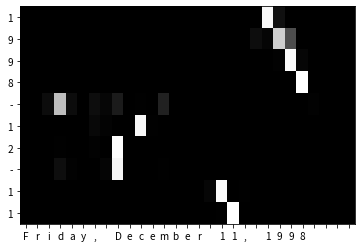

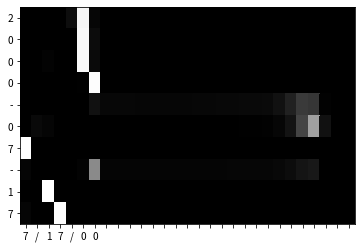

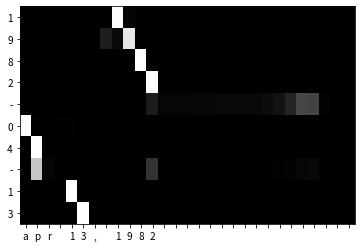

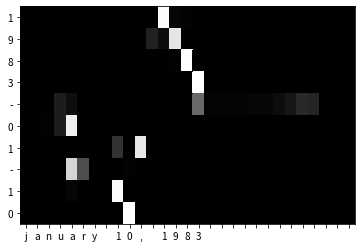

In [19]:
import sys
sys.path.append('..')
import numpy as np
from dataset import sequence
import matplotlib.pyplot as plt
from attention_seq2seq import AttentionSeq2seq


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse input
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # reverse for print
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)

## 8.4 Attentionに関する残りのテーマ

### 8.4.1 双方向RNN

これまでのLSTMに加えて逆方向に処理するLSTMも追加する

２つのLSTMを連結して最終的な隠れ状態ベクトルとする

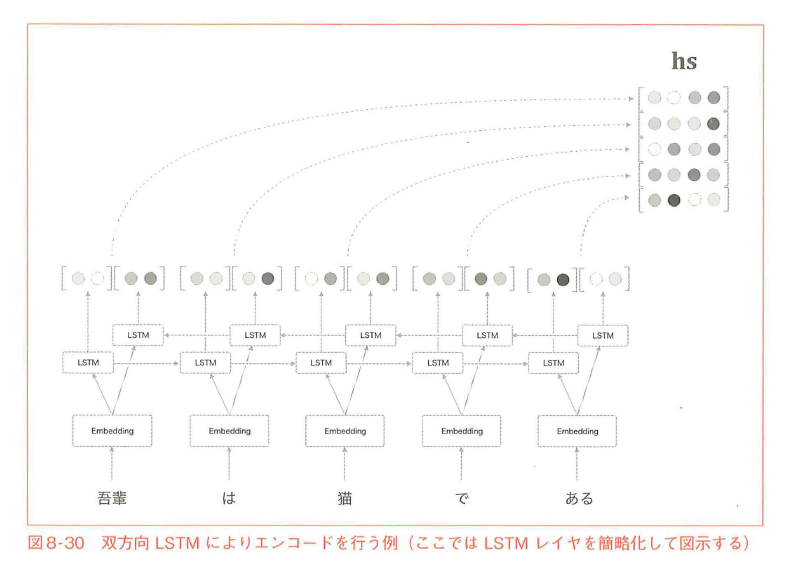

### 8.4.2 Attentionの使用方法

#### LSTM→Attention→Affine

だけでなく

#### Attention→LSTM

として使うと、LSTMがコンテキストベクトルの情報を利用できる

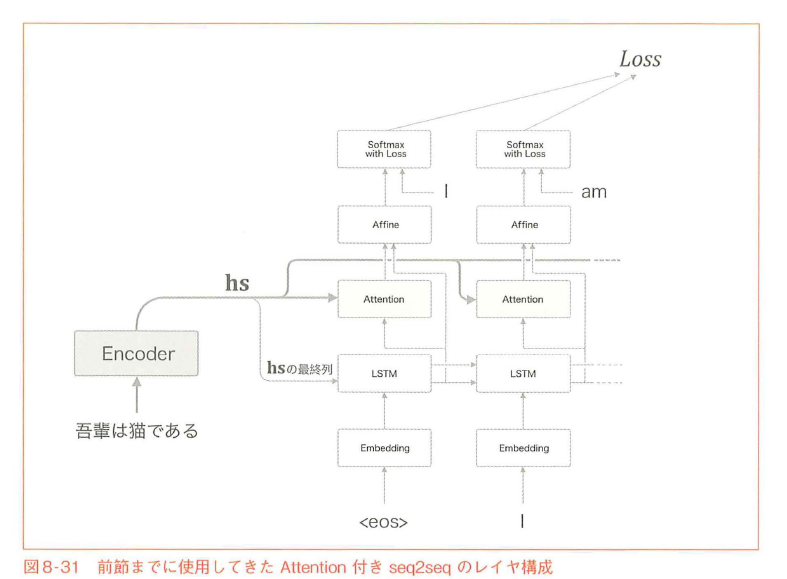

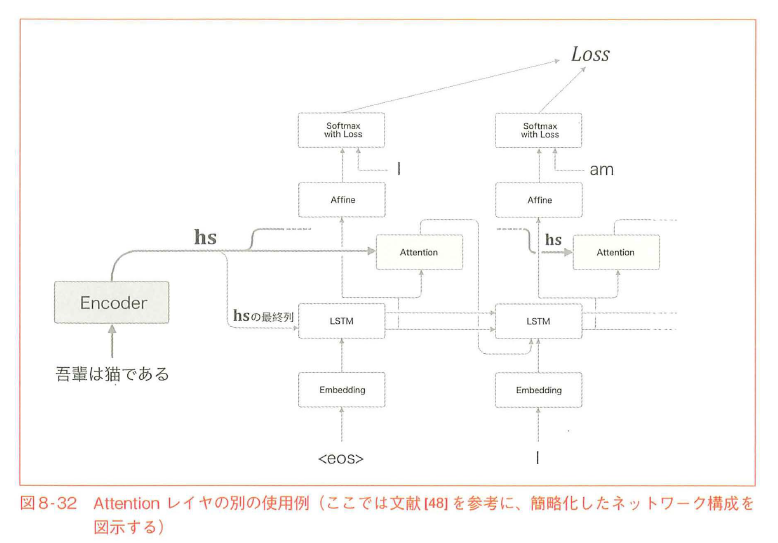

### 8.4.3 seq2seqの深層化とskipコネクション

LSTMを複数層にする方法

Attentionを複数使う方法もある

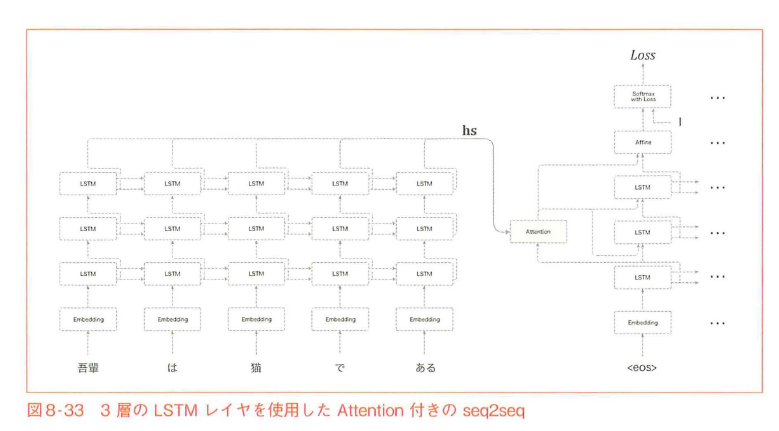

skipコネクション

層を深くするときに、層をまたいで接続し、LSTMの出力を加算する

それにより、逆伝播のときには「そのまま流す」だけなるので勾配爆発または勾配消失が起きにくくなる

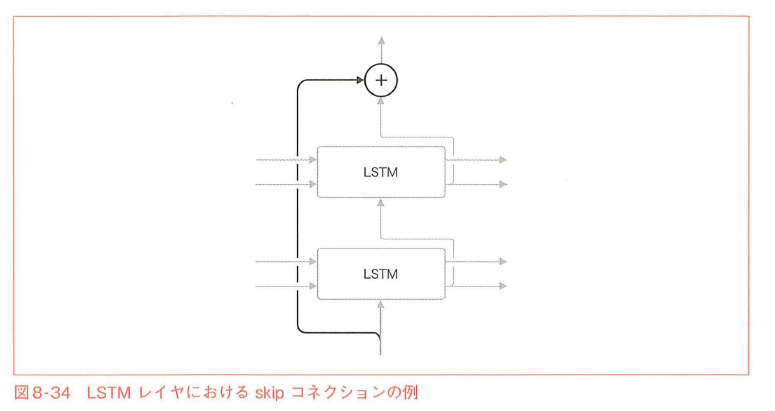

## 8.5 Attentionの応用

### 8.5.1 Google Neural Machine Translation(GNMT)

「ルールベース翻訳」→「用例ベース翻訳」→「統計ベース翻訳」

→「ニューラル翻訳」

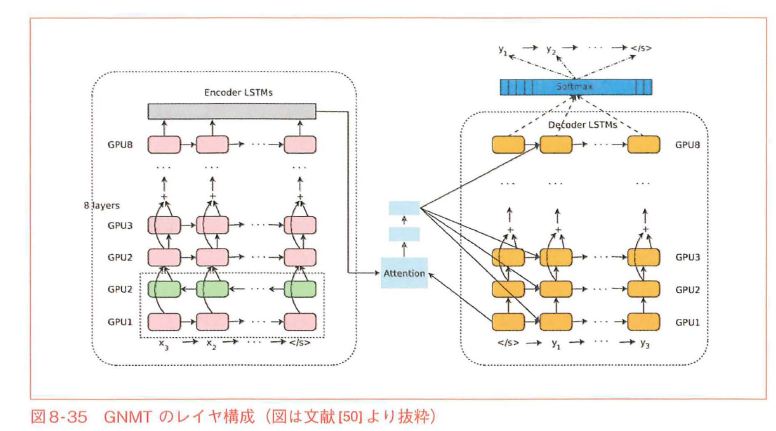

複数CPUでの学習の高速化

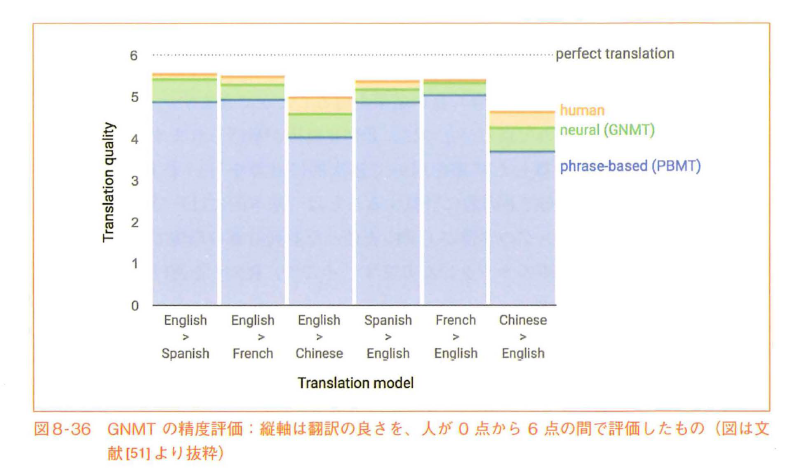

### 8.5.2 Transformer

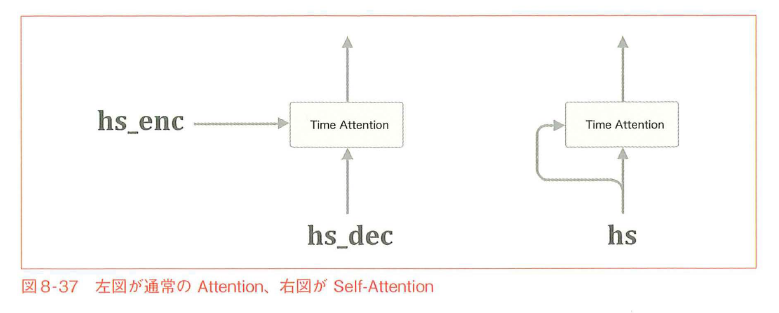

RNNの欠点として、時間方向で並列的に計算することはできない

異なる2つの学習データ

→ひとつの時系列データ内において各要素間の対応関係が求められる

Encoder、Decoderの両方でSelf-Attentionが使われている

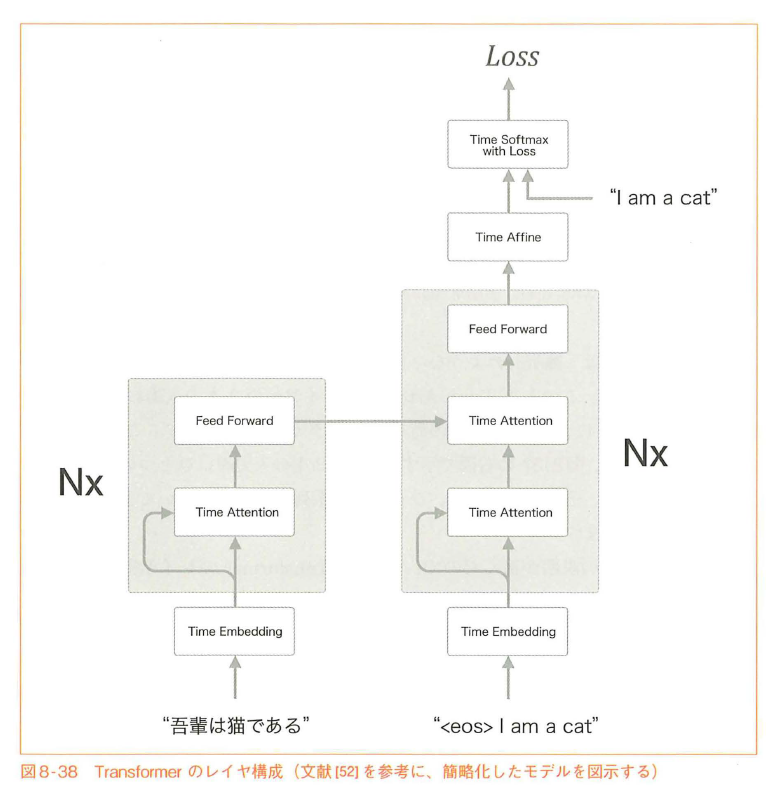

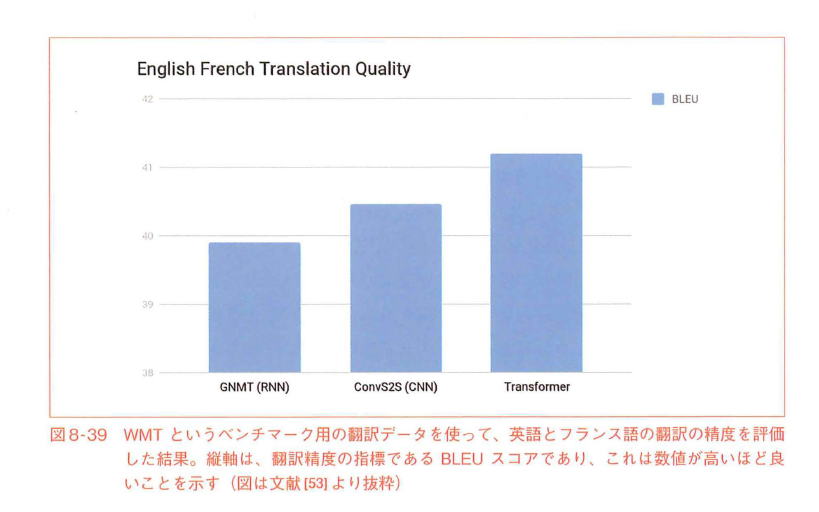

### 8.5.3 Neural Turing Machine(NTM)

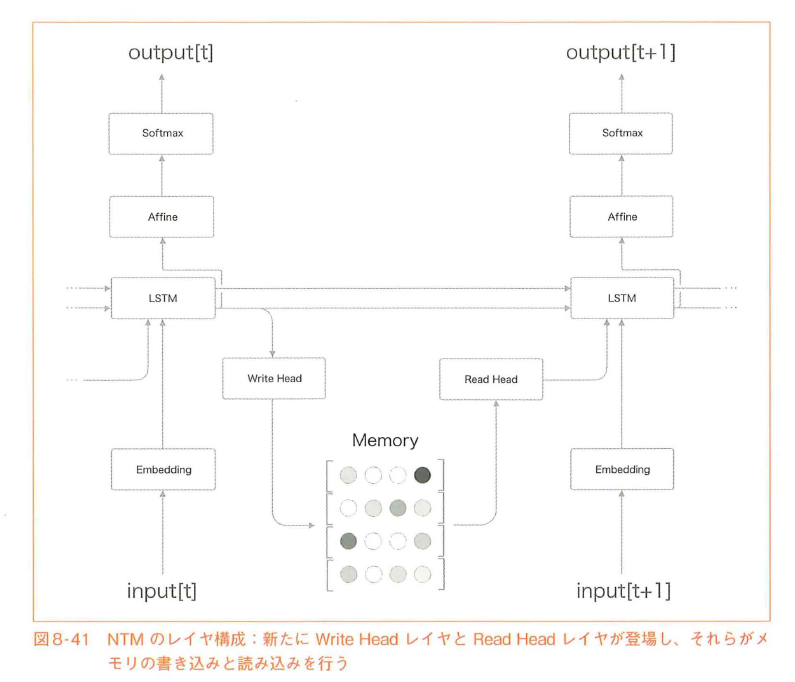

外部メモリによる拡張

RNNの外側に記録した情報をAttentionを使って、そのメモリから必要な情報を引き出す

## 8.6 まとめ

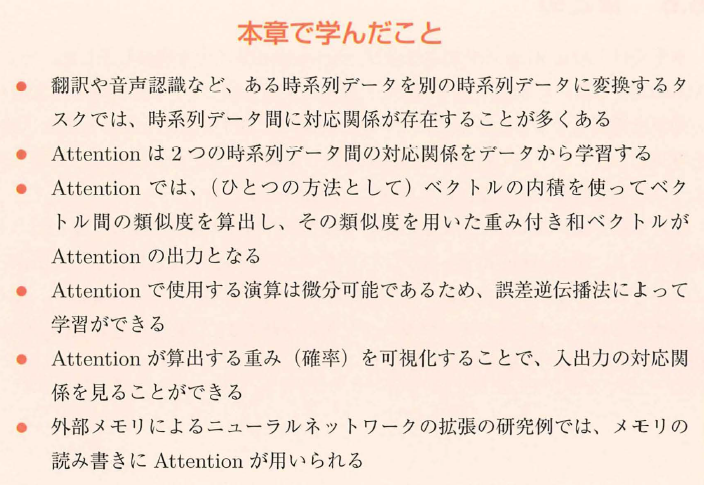